In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


import numpy as np
import matplotlib.pyplot as plt
import scipy

#from google.colab import runtime


In [2]:
#Hyperparameters
lr = 0.00005
momentum = 0 #default = 0
weight_decay = 0.05 #default = 0
dampening = 0 #default = 0

#Other
batch_size = 16
epochs = 30

In [3]:
transforms = {
    'train':
    #Composing several transforms together
    transforms.Compose(
        [
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(),
            transforms.GaussianBlur(1),
            transforms.RandomAdjustSharpness(1),
            transforms.RandomPerspective(),
            transforms.ToTensor(), #To tensor object
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Mean = 0.5, std = 0.5
            transforms.Resize((256,256)) #Speeds up model without losing too much information
        ]),

    'trainOld':
    transforms.Compose(
        [
            transforms.TrivialAugmentWide(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256)),
        ]
    ),

    'val':
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256))
        ]),

    'test':
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256))
        ])
}

In [4]:
train_data = datasets.Flowers102(root='./data', split='train', transform=transforms['train'], download=True)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

100%|██████████| 344862509/344862509 [00:20<00:00, 16696133.64it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 576228.96it/s]


100%|██████████| 14989/14989 [00:00<00:00, 21153574.24it/s]


In [5]:
val_data = datasets.Flowers102(root='./data', split='val', transform=transforms['val'], download=False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [6]:
test_data = datasets.Flowers102(root='./data', split='test', transform=transforms['test'], download=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
#dataloaders = {
#    'train': train_dataloader,
#    'val': val_dataloader
#}

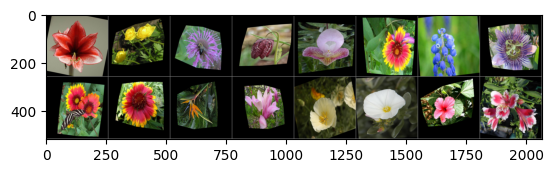

In [8]:
# Show the images in the batch to see what the transforms are doing to them
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_dataloader)
for i in range(1):
  images, lbls = next(dataiter)
  imshow(torchvision.utils.make_grid(images))

In [9]:
#Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [10]:
#Architecture inspired by https://poloclub.github.io/cnn-explainer/#article-input
#and PyTorch for Deep Learning & Machine Learning – Full Course by freeCodeCamp.org https://www.youtube.com/watch?v=V_xro1bcAuA
class CNNv3(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    #Block is comprised of multiple layers
    self.convLayer1 = self.ConvLayers(input_shape, hidden_units)
    self.convLayer2 = self.ConvLayers(hidden_units, hidden_units)
    self.convLayer3 = self.ConvLayers(hidden_units, hidden_units)
    self.convLayer4 = self.ConvLayers(hidden_units, hidden_units)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=1024),
        nn.ReLU(),
        nn.Linear(in_features=1024,
                  out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512,
                  out_features=output_shape)

    )

  def ConvLayers(self, input_shape, hidden_units):
    return nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

  def forward(self, x):
    x = self.convLayer1(x)
    #print(x.shape)
    x = self.convLayer2(x)
    #print(x.shape)
    x = self.convLayer3(x)
    #print(x.shape)
    x = self.convLayer4(x)
    #print(x.shape)
    x = self.classifier(x)
    return x

In [11]:
model = CNNv3(input_shape=3,
              hidden_units=102,
              output_shape=102).to(device)
print(model)

CNNv2(
  (convLayer1): Sequential(
    (0): Conv2d(3, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer2): Sequential(
    (0): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer3): Sequential(
   

In [12]:
#Loss function and optimiser
loss_fn = nn.CrossEntropyLoss()
#optimiser = torch.optim.SGD(model.parameters(),
#                            lr=lr,
#                            momentum=momentum,
#                            weight_decay=weight_decay,
#                            dampening=dampening)
optimiser = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)


In [13]:
#Train the model using the training data
def train(dataloader, model, loss_fn, optimiser):
  size = len(dataloader.dataset)
  batches = len(dataloader)
  model.train()
  running_loss, running_corrects = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    running_loss += loss.item()
    running_corrects += torch.count_nonzero(pred.argmax(1)==y).item()

    # Backpropagation
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()

  ave_loss = running_loss/batches
  corrects = running_corrects/size

  print(f"Train Error: \nAccuracy: {(100*corrects):.2f}%, Avg loss: {ave_loss:.6f} \n")
  return ave_loss, corrects


In [14]:
#Validate the models progress using the validation data
def valTest(dataloader, model, loss_fn, split):
  size = len(dataloader.dataset)
  batches = len(dataloader)
  model.eval()
  running_loss, running_corrects = 0, 0

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss = loss_fn(pred,y)

      running_loss += loss.item()
      running_corrects += torch.count_nonzero(pred.argmax(1)==y).item()

  ave_loss = running_loss/batches
  corrects = running_corrects/size

  print(f"{split} Error: \n Accuracy: {(100*corrects):.2f}%, Avg loss: {ave_loss:.6f} \n")

  return ave_loss, corrects


In [15]:
def pltHist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(121)
  plt.plot(hist['train_loss'],'-o')
  plt.plot(hist['val_loss'],'-o')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Train','Val'])
  plt.title('Train vs Validation loss')

  plt.subplot(122)
  plt.plot(hist['train_accuracy'],'-o')
  plt.plot(hist['val_accuracy'],'-o')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Val'])
  plt.title('Train vs Validation Accuracy')

In [16]:
def trainValLoop(model, loss_fn, optimiser, epochs):
  train_loss_hist = []
  train_acc_hist = []
  val_loss_hist = []
  val_acc_hist = []

  for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs} -------------------------------")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimiser)
    val_loss, val_acc = valTest(val_dataloader, model, loss_fn, 'Validate')

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

  hist = {'train_loss':train_loss_hist, 'train_accuracy':train_acc_hist,
          'val_loss':val_loss_hist, 'val_accuracy':val_acc_hist}
  pltHist(hist)
  valTest(test_dataloader, model, loss_fn, 'Test')

  return hist


Epoch 1/30 -------------------------------
Train Error: 
Accuracy: 0.88%, Avg loss: 4.662473 

Validate Error: 
 Accuracy: 3.73%, Avg loss: 4.468108 

Epoch 2/30 -------------------------------
Train Error: 
Accuracy: 3.82%, Avg loss: 4.382290 

Validate Error: 
 Accuracy: 5.10%, Avg loss: 4.106562 

Epoch 3/30 -------------------------------
Train Error: 
Accuracy: 6.18%, Avg loss: 4.069773 

Validate Error: 
 Accuracy: 9.31%, Avg loss: 3.837828 

Epoch 4/30 -------------------------------
Train Error: 
Accuracy: 8.33%, Avg loss: 3.831164 

Validate Error: 
 Accuracy: 13.73%, Avg loss: 3.621558 

Epoch 5/30 -------------------------------
Train Error: 
Accuracy: 12.16%, Avg loss: 3.600293 

Validate Error: 
 Accuracy: 14.22%, Avg loss: 3.565336 

Epoch 6/30 -------------------------------
Train Error: 
Accuracy: 15.88%, Avg loss: 3.386634 

Validate Error: 
 Accuracy: 18.82%, Avg loss: 3.348688 

Epoch 7/30 -------------------------------
Train Error: 
Accuracy: 20.20%, Avg loss: 3.22

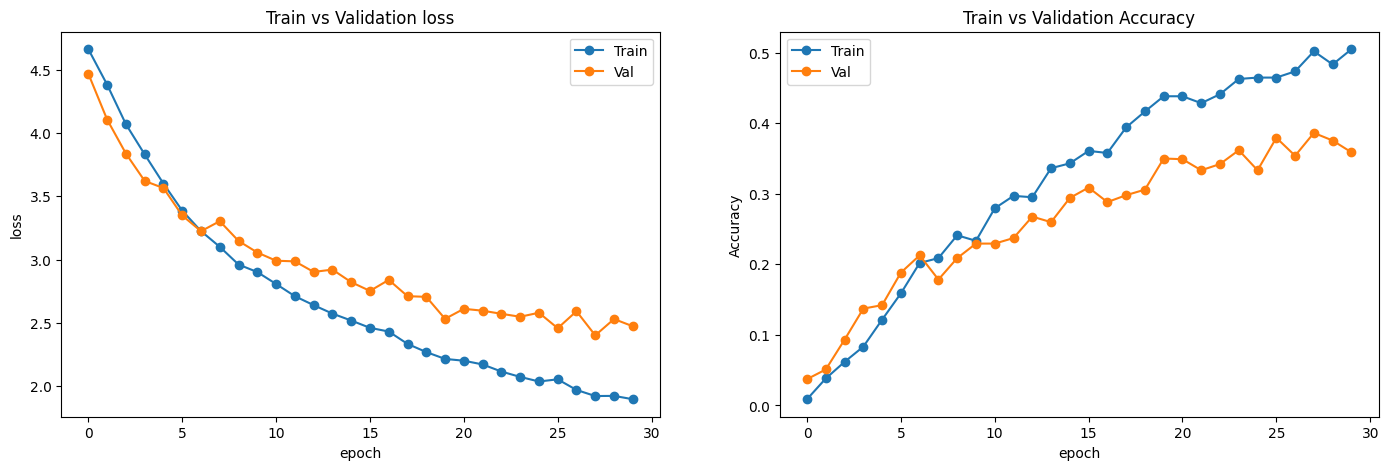

In [17]:
hist = trainValLoop(model, loss_fn, optimiser, epochs)

In [18]:
PATH = './CNNv1.pth'
torch.save(model.state_dict(), PATH)

In [19]:
print("#Hyperparameters")
print(f"lr = {lr:.5f}")
print(f"momentum = {momentum}")
print(f"weight_decay = {weight_decay}")
print(f"dampening = {dampening}")
print()
print("#Other")
print(f"batch_size = {batch_size}")
print(f"epochs = {epochs}")

#Hyperparameters
lr = 0.00005
momentum = 0
weight_decay = 0.05
dampening = 0

#Other
batch_size = 16
epochs = 30


In [20]:
print(hist)

{'train_loss': [4.662472516298294, 4.382289998233318, 4.069773234426975, 3.8311643078923225, 3.6002930738031864, 3.386633664369583, 3.2251382172107697, 3.100905913859606, 2.9610407389700413, 2.901552125811577, 2.8072511926293373, 2.71080057695508, 2.640168510377407, 2.573305666446686, 2.51867750659585, 2.460969388484955, 2.431597128510475, 2.333934547379613, 2.269347444176674, 2.2152058947831392, 2.2010992635041475, 2.1716932225972414, 2.1155022755265236, 2.0731889344751835, 2.036912841722369, 2.0539709720760584, 1.9701799433678389, 1.9219786506146193, 1.9231812674552202, 1.8968112710863352], 'train_accuracy': [0.008823529411764706, 0.03823529411764706, 0.061764705882352944, 0.08333333333333333, 0.12156862745098039, 0.1588235294117647, 0.2019607843137255, 0.2088235294117647, 0.2411764705882353, 0.23333333333333334, 0.27941176470588236, 0.29705882352941176, 0.2950980392156863, 0.3362745098039216, 0.3431372549019608, 0.3607843137254902, 0.35784313725490197, 0.3941176470588235, 0.41666666

In [21]:
#Stops Google stealing my credits
#runtime.unassign()

In [22]:
#histVik =
#pltHist(histVik)

3409182720